https://machinebox.io/docs/tagbox/recognizing-images

In [24]:
import requests
import operator
import os
import io
import base64
import pathlib
from PIL import Image
import json
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import sys
print(sys.version)

ATTR_NAME = 'name'
ATTR_CONFIDENCE = 'confidence'
HEADERS = {'content-type': 'application/json'} ; # charset=utf-8
ENDPOINT = "http://localhost:8080/tagbox/check"
#ENDPOINT = "http://192.168.0.30:8080/tagbox/check"

def download_image(url):
    """"Convenience to download web image."""
    file_name = url.split("/")[-1]
    with open(file_name, "wb") as file:
        response = requests.get(url)
        file.write(response.content)
        print(file_name + " downloaded from " + url)
    return file_name

def print_json(json_data):
    PrettyPrinter().pprint(json_data)

3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
ls

Classification box introduction.ipynb  cat.2.jpg
Classificationbox images.ipynb         model_sentiment1.classificationbox
Facebox.ipynb                          monkey.jpg
Facebox_HA_development.ipynb           people.jpg
Tagbox tag images.ipynb                person.jpg
cat.1.jpg                              thebeatles.jpg


In [3]:
# url = "https://machinebox.io/samples/images/monkey.jpg"

In [4]:
# file_name = download_image(url)
file_name = 'people.jpg'
#file_name = 'person.jpg'

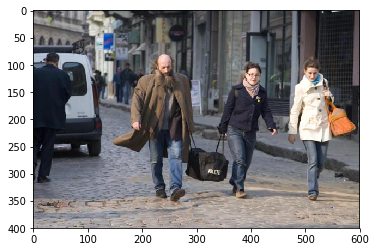

In [5]:
img = plt.imread(file_name)  # Creates an ndarray
plt.imshow(img)
plt.show()

## Post the file

In [6]:
%%time
files = {
    'file': (file_name, open(file_name, 'rb')),
}

response = requests.post(ENDPOINT, files=files)

CPU times: user 8.37 ms, sys: 4.25 ms, total: 12.6 ms
Wall time: 1.39 s


In [7]:
print_json(response.json())

{'custom_tags': [],
 'success': True,
 'tags': [{'confidence': 0.8022336363792419, 'tag': 'Road'},
          {'confidence': 0.7897472381591797, 'tag': 'Street'},
          {'confidence': 0.6975526809692383, 'tag': 'Pedestrian'},
          {'confidence': 0.462933212518692, 'tag': 'Infrastructure'},
          {'confidence': 0.3945978879928589, 'tag': 'People'},
          {'confidence': 0.3616401255130768, 'tag': 'Crowd'}]}


## Post bytes

In [8]:
img_file_data = pathlib.Path('monkey.jpg').read_bytes()

In [9]:
base64_img = base64.b64encode(img_file_data).decode('ascii')

In [10]:
HEADER = {'content-type': 'application/json, charset=utf-8'}
response = requests.post(ENDPOINT, headers=HEADER, json={"base64": base64_img}).json()

In [11]:
print_json(response)

{'custom_tags': [],
 'success': True,
 'tags': [{'confidence': 0.9197548031806946, 'tag': 'Wildlife'},
          {'confidence': 0.8748621940612793, 'tag': 'Animal'},
          {'confidence': 0.8732861876487732,
           'tag': 'Pre-dreadnought battleship'},
          {'confidence': 0.8389277458190918, 'tag': 'Primate'},
          {'confidence': 0.8311088681221008, 'tag': 'Mammal'},
          {'confidence': 0.736111581325531, 'tag': 'Jungle'},
          {'confidence': 0.6977391839027405, 'tag': 'Monkey'},
          {'confidence': 0.5723546147346497, 'tag': 'Rainforest'},
          {'confidence': 0.4915062487125397, 'tag': 'Ape'},
          {'confidence': 0.46555307507514954, 'tag': 'Zoo'}]}


In [18]:
api_tags = response['tags'] + response['custom_tags'] 
api_tags

[{'tag': 'Wildlife', 'confidence': 0.9197548031806946},
 {'tag': 'Animal', 'confidence': 0.8748621940612793},
 {'tag': 'Pre-dreadnought battleship', 'confidence': 0.8732861876487732},
 {'tag': 'Primate', 'confidence': 0.8389277458190918},
 {'tag': 'Mammal', 'confidence': 0.8311088681221008},
 {'tag': 'Jungle', 'confidence': 0.736111581325531},
 {'tag': 'Monkey', 'confidence': 0.6977391839027405},
 {'tag': 'Rainforest', 'confidence': 0.5723546147346497},
 {'tag': 'Ape', 'confidence': 0.4915062487125397},
 {'tag': 'Zoo', 'confidence': 0.46555307507514954}]

In [28]:
[entry['tag'] for entry in api_tags]

['Wildlife',
 'Animal',
 'Pre-dreadnought battleship',
 'Primate',
 'Mammal',
 'Jungle',
 'Monkey',
 'Rainforest',
 'Ape',
 'Zoo']

In [19]:
special_tags = ['people'] # Tags we always want to appear in tag data, even with confidence 0 when not present

# Parse API data

In [33]:
def parse_tags(api_tags, special_tags):
    """Process API data and ensure special_tags are present."""
    parsed_tags = []
    for entry in api_tags:
        tag = {}
        tag[ATTR_NAME] = entry['tag']
        tag[ATTR_CONFIDENCE] = round(entry['confidence'], 2)
        parsed_tags.append(tag)
    current_tags = [entry['tag'] for entry in api_tags]
    for entry in special_tags:
        if entry not in current_tags:
            tag = {}
            tag[ATTR_NAME] = entry
            tag[ATTR_CONFIDENCE] = 0.0
            parsed_tags.append(tag)
    return parsed_tags

In [36]:
parse_tags(api_tags, special_tags)

[{'name': 'Wildlife', 'confidence': 0.92},
 {'name': 'Animal', 'confidence': 0.87},
 {'name': 'Pre-dreadnought battleship', 'confidence': 0.87},
 {'name': 'Primate', 'confidence': 0.84},
 {'name': 'Mammal', 'confidence': 0.83},
 {'name': 'Jungle', 'confidence': 0.74},
 {'name': 'Monkey', 'confidence': 0.7},
 {'name': 'Rainforest', 'confidence': 0.57},
 {'name': 'Ape', 'confidence': 0.49},
 {'name': 'Zoo', 'confidence': 0.47},
 {'name': 'people', 'confidence': 0.0}]

In [39]:
parse_tags([], special_tags)

[{'name': 'people', 'confidence': 0.0}]

In [14]:
classifications  = {'Pet': 92.2, 'Dog': 84.4, 'Mammal': 59.4, 'Animal': 58.4}

In [15]:
next(iter(classifications))

'Pet'

In [16]:
classifications = {item['tag']: round(100.0*item['confidence'], 1) for item in tags}
classifications = sorted(classifications.items(), key=operator.itemgetter(1))
classifications.reverse()
classifications

NameError: name 'tags' is not defined

In [ ]:
classifications[0][0]

# Dev stuff

In [ ]:
tags = [{'tag': 'People', 'confidence': 0.9419352412223816}, 
        {'tag': 'Black-and-white', 'confidence': 0.7725128531455994}, 
        {'tag': 'Person', 'confidence': 0.7546272873878479}, 
        {'tag': 'Social group', 'confidence': 0.6093477606773376}, 
        {'tag': 'Team', 'confidence': 0.5515936017036438}, 
        {'tag': 'Monochrome photography', 'confidence': 0.5179617404937744}, 
        {'tag': 'Musician', 'confidence': 0.47986897826194763}, 
        {'tag': 'Monochrome', 'confidence': 0.41039228439331055}]

In [ ]:
def format_tags(tags):
    """Return the formatted name and rounded confidence of tags."""
    return {tag['tag'].lower(): round(tag['confidence'], 2) for tag in tags}

In [ ]:
format_tags(tags)

In [38]:
for tag in []:
    print('foo')